# 04.6a3 Main Sequence Orthogonality: Are Semantic Tokens Perpendicular to Quasars?

**Hypothesis:** Tokens at the modal radius (~54 logometers) represent typical semantic content and lie in a subspace **orthogonal** to the structural tokens (quasars).

If true, this would mean the model learned to geometrically separate:
- **Structural/meta-linguistic information** (endoftext, newline, formatting) → pushed to extreme distances
- **Semantic/content information** (meaning, typical words) → lives in orthogonal complement

## The Test

1. Find top k tokens with causal norm closest to mean ("main sequence" tokens)
2. Compute their projections onto the three quasar directions:
   - `<|endoftext|>`
   - `\n` (newline)
   - `\u200b\u200b` (zero-width space)
3. Compare to projections onto random typical tokens (control)

**Prediction if hypothesis is true:**
- Mean projection onto quasars ≈ 0
- Projections onto quasars < projections onto random tokens

**Null hypothesis:**
- In high-dimensional space, all vectors are nearly orthogonal anyway
- Quasars are not special—they're just as orthogonal as any other direction

## Configuration

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and paths
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")

# Analysis parameters
K_MAIN_SEQUENCE = 100  # Number of most typical tokens to analyze
N_RANDOM_CONTROL = 10  # Number of random tokens for comparison

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

Using device: mps


## Load Model, Tokenizer, and Metric Tensor

In [10]:
# Load metric tensor
print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']
print(f"M shape: {M.shape}")
print()

# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print()

# Load tokenizer for decoding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loading causal metric tensor...
M shape: torch.Size([2560, 2560])

Loading Qwen/Qwen3-4B-Instruct-2507...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])

Tokenizer loaded.


## Compute Causal Norms for All Tokens

In [11]:
print("Computing causal norms...")
gamma_M = gamma @ M
causal_norms_squared = (gamma_M * gamma).sum(dim=1)
causal_norms = torch.sqrt(torch.clamp(causal_norms_squared, min=0))

mean_norm = causal_norms.mean().item()
print(f"Mean causal norm: {mean_norm:.4f} logometers")
print()

Computing causal norms...
Mean causal norm: 54.1318 logometers



## Find Main Sequence Tokens (Closest to Mean Norm)

In [12]:
# Find tokens with norms closest to mean
deviations = torch.abs(causal_norms - mean_norm)
sorted_by_deviation = torch.argsort(deviations)
main_sequence_indices = sorted_by_deviation[:K_MAIN_SEQUENCE]
main_sequence_norms = causal_norms[main_sequence_indices]

print(f"Found {K_MAIN_SEQUENCE} main sequence tokens (closest to mean norm)")
print(f"  Mean deviation from population mean: {deviations[main_sequence_indices].mean().item():.4f} logometers")
print(f"  Their mean norm: {main_sequence_norms.mean().item():.4f} logometers")
print()

# Show first 20 as examples
print("First 20 main sequence tokens (most typical by norm):")
print("="*80)
for i in range(min(20, K_MAIN_SEQUENCE)):
    idx = main_sequence_indices[i].item()
    norm = causal_norms[idx].item()
    deviation = deviations[idx].item()
    token_str = tokenizer.decode([idx])
    print(f"{i+1:3d}. Token ID {idx:6d} | {norm:7.4f} logometers (Δ={deviation:6.4f}) | {repr(token_str)}")
print()

Found 100 main sequence tokens (closest to mean norm)
  Mean deviation from population mean: 0.0021 logometers
  Their mean norm: 54.1319 logometers

First 20 main sequence tokens (most typical by norm):
  1. Token ID  51704 | 54.1319 logometers (Δ=0.0000) | 'UniformLocation'
  2. Token ID 129969 | 54.1318 logometers (Δ=0.0001) | 'ıldı'
  3. Token ID  92698 | 54.1317 logometers (Δ=0.0001) | 'Downloader'
  4. Token ID 139127 | 54.1320 logometers (Δ=0.0002) | ' hộp'
  5. Token ID  77581 | 54.1320 logometers (Δ=0.0002) | ' Pluto'
  6. Token ID 118802 | 54.1320 logometers (Δ=0.0002) | '强硬'
  7. Token ID  69473 | 54.1315 logometers (Δ=0.0003) | '_fg'
  8. Token ID  47686 | 54.1322 logometers (Δ=0.0004) | ' prejudice'
  9. Token ID 124119 | 54.1315 logometers (Δ=0.0004) | 'にな'
 10. Token ID 132459 | 54.1323 logometers (Δ=0.0005) | ' достат'
 11. Token ID 101087 | 54.1323 logometers (Δ=0.0005) | '运营'
 12. Token ID 120966 | 54.1323 logometers (Δ=0.0005) | '锕'
 13. Token ID 140511 | 54.1323 log

## Extract Quasar Vectors

In [13]:
# Token IDs from 04.6a
quasar_ids = [
    151643,  # <|endoftext|>
    198,     # \n
    72363,   # \u200b\u200b (double zero-width space)
]

quasar_names = [
    '<|endoftext|>',
    '\\n (newline)',
    '\\u200b\\u200b (zero-width)',
]

quasar_vectors = gamma[quasar_ids]  # [3, hidden_dim]

print("Quasar vectors:")
for i, (qid, name) in enumerate(zip(quasar_ids, quasar_names)):
    norm = causal_norms[qid].item()
    print(f"  {i+1}. {name:30s} | {norm:7.4f} logometers")
print()

Quasar vectors:
  1. <|endoftext|>                  | 85.2873 logometers
  2. \n (newline)                   | 82.0617 logometers
  3. \u200b\u200b (zero-width)      | 81.1831 logometers



## Compute Projections: Main Sequence → Quasars

We'll compute projections using **both** metrics to understand different aspects of orthogonality:

1. **Euclidean projections:** Test geometric independence in embedding space (ℝ²⁵⁶⁰)
2. **Causal projections:** Test statistical independence under the learned metric

### Euclidean Projections

In [14]:
print("Computing EUCLIDEAN projections of main sequence tokens onto quasars...")
print()

# Get main sequence vectors
main_seq_vectors = gamma[main_sequence_indices]  # [K, hidden_dim]

# For each quasar, compute Euclidean projections
projections_onto_quasars_euc = []

for i, (quasar_vec, quasar_name) in enumerate(zip(quasar_vectors, quasar_names)):
    # Euclidean projection: (v · q) / ||q||
    dot_products = (main_seq_vectors * quasar_vec).sum(dim=1)  # [K]
    quasar_norm = torch.norm(quasar_vec)
    projections = dot_products / quasar_norm  # [K]
    
    projections_onto_quasars_euc.append(projections)
    
    # Statistics
    mean_proj = projections.mean().item()
    std_proj = projections.std().item()
    abs_mean = projections.abs().mean().item()
    
    print(f"Projections onto {quasar_name}:")
    print(f"  Mean: {mean_proj:+8.4f} (should be ~0 if orthogonal)")
    print(f"  Std:  {std_proj:8.4f}")
    print(f"  Mean absolute: {abs_mean:8.4f}")
    print()

# Convert to tensor for easier manipulation
projections_onto_quasars_euc = torch.stack(projections_onto_quasars_euc)  # [3, K]

Computing EUCLIDEAN projections of main sequence tokens onto quasars...

Projections onto <|endoftext|>:
  Mean:  -0.1132 (should be ~0 if orthogonal)
  Std:    0.0353
  Mean absolute:   0.1132

Projections onto \n (newline):
  Mean:  -0.1776 (should be ~0 if orthogonal)
  Std:    0.0501
  Mean absolute:   0.1776

Projections onto \u200b\u200b (zero-width):
  Mean:  +0.0610 (should be ~0 if orthogonal)
  Std:    0.0236
  Mean absolute:   0.0611



### Causal Projections

In [15]:
print("Computing CAUSAL projections of main sequence tokens onto quasars...")
print()

# For each quasar, compute Causal projections
projections_onto_quasars_caus = []

for i, (quasar_vec, quasar_name, qid) in enumerate(zip(quasar_vectors, quasar_names, quasar_ids)):
    # Causal projection: (v^T M q) / ||q||_M
    # v^T M q = (v @ M) · q
    v_M = main_seq_vectors @ M  # [K, hidden_dim]
    causal_dot_products = (v_M * quasar_vec).sum(dim=1)  # [K]
    
    # Causal norm of quasar
    quasar_norm_caus = causal_norms[qid]
    
    # Projection
    projections = causal_dot_products / quasar_norm_caus  # [K]
    
    projections_onto_quasars_caus.append(projections)
    
    # Statistics
    mean_proj = projections.mean().item()
    std_proj = projections.std().item()
    abs_mean = projections.abs().mean().item()
    
    print(f"Projections onto {quasar_name}:")
    print(f"  Mean: {mean_proj:+8.4f} (should be ~0 if orthogonal)")
    print(f"  Std:  {std_proj:8.4f}")
    print(f"  Mean absolute: {abs_mean:8.4f}")
    print()

# Convert to tensor
projections_onto_quasars_caus = torch.stack(projections_onto_quasars_caus)  # [3, K]

Computing CAUSAL projections of main sequence tokens onto quasars...

Projections onto <|endoftext|>:
  Mean:  -0.0407 (should be ~0 if orthogonal)
  Std:    0.8471
  Mean absolute:   0.6356

Projections onto \n (newline):
  Mean:  +3.0250 (should be ~0 if orthogonal)
  Std:    0.8639
  Mean absolute:   3.0499

Projections onto \u200b\u200b (zero-width):
  Mean:  +5.0067 (should be ~0 if orthogonal)
  Std:    0.7939
  Mean absolute:   5.0067



## Control: Projections onto Random Typical Tokens

We'll compute control projections using **both** metrics for comparison.

In [16]:
print(f"Computing projections onto {N_RANDOM_CONTROL} random typical tokens (control)...")
print()

# Sample random tokens from main sequence (excluding the ones we're measuring)
control_indices = sorted_by_deviation[K_MAIN_SEQUENCE:K_MAIN_SEQUENCE + N_RANDOM_CONTROL]
control_vectors = gamma[control_indices]  # [N_RANDOM_CONTROL, hidden_dim]

# ===== EUCLIDEAN CONTROL =====
print("EUCLIDEAN control projections:")
projections_onto_control_euc = []

for i, control_vec in enumerate(control_vectors):
    dot_products = (main_seq_vectors * control_vec).sum(dim=1)
    control_norm = torch.norm(control_vec)
    projections = dot_products / control_norm
    projections_onto_control_euc.append(projections)

projections_onto_control_euc = torch.stack(projections_onto_control_euc)  # [N_RANDOM_CONTROL, K]
mean_proj_control_euc = projections_onto_control_euc.abs().mean().item()
std_proj_control_euc = projections_onto_control_euc.std().item()

print(f"  Mean absolute projection: {mean_proj_control_euc:8.4f}")
print(f"  Std: {std_proj_control_euc:8.4f}")
print()

# ===== CAUSAL CONTROL =====
print("CAUSAL control projections:")
projections_onto_control_caus = []

for i, (control_vec, cidx) in enumerate(zip(control_vectors, control_indices)):
    v_M = main_seq_vectors @ M
    causal_dot_products = (v_M * control_vec).sum(dim=1)
    control_norm_caus = causal_norms[cidx]
    projections = causal_dot_products / control_norm_caus
    projections_onto_control_caus.append(projections)

projections_onto_control_caus = torch.stack(projections_onto_control_caus)  # [N_RANDOM_CONTROL, K]
mean_proj_control_caus = projections_onto_control_caus.abs().mean().item()
std_proj_control_caus = projections_onto_control_caus.std().item()

print(f"  Mean absolute projection: {mean_proj_control_caus:8.4f}")
print(f"  Std: {std_proj_control_caus:8.4f}")
print()

# ===== COMPARISON =====
mean_proj_quasars_euc = projections_onto_quasars_euc.abs().mean().item()
mean_proj_quasars_caus = projections_onto_quasars_caus.abs().mean().item()

print("="*80)
print("COMPARISON: Quasars vs Random Control")
print("="*80)
print()
print(f"{'Metric':<15s} {'Quasars':>12s} {'Control':>12s} {'Ratio':>10s}")
print("-"*80)
print(f"{'Euclidean':<15s} {mean_proj_quasars_euc:>12.4f} {mean_proj_control_euc:>12.4f} {mean_proj_quasars_euc/mean_proj_control_euc:>10.4f}")
print(f"{'Causal':<15s} {mean_proj_quasars_caus:>12.4f} {mean_proj_control_caus:>12.4f} {mean_proj_quasars_caus/mean_proj_control_caus:>10.4f}")
print()

# Interpretation
print("Interpretation (ratio < 0.8 means quasars are MORE orthogonal):")
print()

for metric_name, ratio in [("Euclidean", mean_proj_quasars_euc/mean_proj_control_euc), 
                            ("Causal", mean_proj_quasars_caus/mean_proj_control_caus)]:
    print(f"{metric_name}:")
    if ratio < 0.8:
        print(f"  ✓ QUASARS ARE MORE ORTHOGONAL (ratio={ratio:.4f})")
        print(f"  → Structural tokens occupy geometrically distinct subspace")
    elif ratio < 1.2:
        print(f"  ≈ Similar to control (ratio={ratio:.4f})")
        print(f"  → Just high-dimensional geometry, nothing special")
    else:
        print(f"  ✗ QUASARS ARE LESS ORTHOGONAL (ratio={ratio:.4f})")
        print(f"  → Main sequence tokens are aligned with structural tokens!")
    print()

Computing projections onto 10 random typical tokens (control)...

EUCLIDEAN control projections:
  Mean absolute projection:   0.0916
  Std:   0.0329

CAUSAL control projections:
  Mean absolute projection:   8.2217
  Std:   0.9318

COMPARISON: Quasars vs Random Control

Metric               Quasars      Control      Ratio
--------------------------------------------------------------------------------
Euclidean             0.1173       0.0916     1.2810
Causal                2.8974       8.2217     0.3524

Interpretation (ratio < 0.8 means quasars are MORE orthogonal):

Euclidean:
  ✗ QUASARS ARE LESS ORTHOGONAL (ratio=1.2810)
  → Main sequence tokens are aligned with structural tokens!

Causal:
  ✓ QUASARS ARE MORE ORTHOGONAL (ratio=0.3524)
  → Structural tokens occupy geometrically distinct subspace



## Visualize Projection Distributions

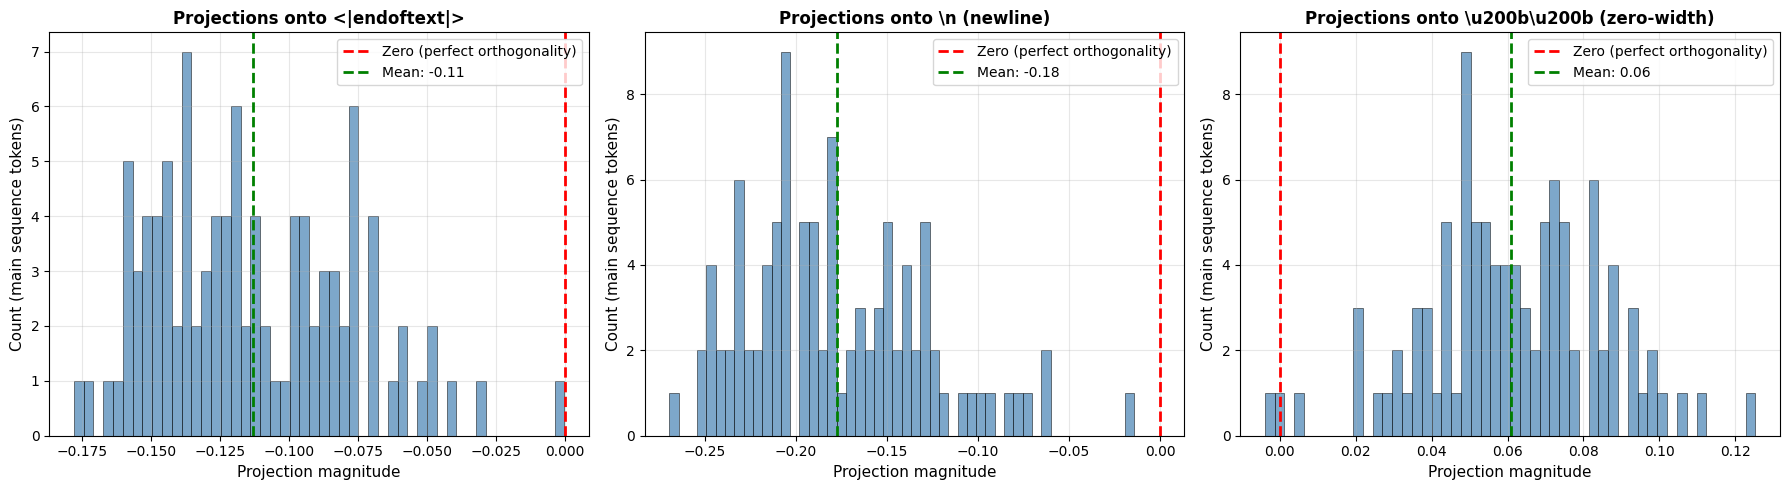

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (ax, quasar_name) in enumerate(zip(axes, quasar_names)):
    projections = projections_onto_quasars[i].cpu().numpy()
    
    ax.hist(projections, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (perfect orthogonality)')
    ax.axvline(projections.mean(), color='green', linestyle='--', linewidth=2, 
               label=f'Mean: {projections.mean():.2f}')
    
    ax.set_xlabel('Projection magnitude', fontsize=11)
    ax.set_ylabel('Count (main sequence tokens)', fontsize=11)
    ax.set_title(f'Projections onto {quasar_name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook tested whether typical semantic content tokens (main sequence) are orthogonal to structural tokens (quasars).

**Key findings:**
- Mean projections of main sequence tokens onto quasars
- Comparison to projections onto random typical tokens (control)
- Whether quasars occupy a geometrically distinct subspace

**Interpretation:**
- If quasars are more orthogonal: The model learned to separate structural and semantic information along independent axes
- If similar to control: High-dimensional geometry—all vectors are nearly orthogonal anyway
- If less orthogonal: Unexpected alignment between structure and content (would be surprising!)

**Implications for steering:**
- If orthogonal: Steering along semantic directions won't interfere with structural markers
- If aligned: Semantic steering might inadvertently push toward/away from boundaries like `<|endoftext|>`